In [1]:
## Imports
from google.colab import drive

import torch 
import torchvision
import torchvision.transforms as tf

import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
import tarfile
import sys
import numpy as np

from IPython.display import clear_output

## Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/DeepLearning_2022/Project/Data/'
results_path = '/content/drive/Shared drives/DeepLearning_2022/Project/Results/'

Mounted at /content/drive


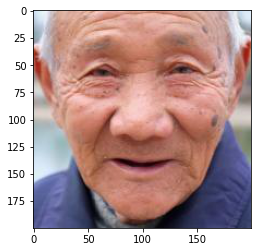

torch.Size([1, 3, 200, 200])
Img: 8376
image: 64
image_pt: 88


In [2]:
with tarfile.open(data_path+'UTKFace.tar.gz', 'r') as file:
  for i, member in enumerate(file.getmembers()):
    Img = file.extractfile(member)

    image = Image.open(Img)
    plt.imshow(image)
    plt.show()
    # converts to tensor
    to_tensor_tf = tf.ToTensor()
    image_pt = to_tensor_tf(image)
    image_pt = image_pt.unsqueeze(0)
    print(image_pt.shape)
    print("Img:",sys.getsizeof(Img))
    print("image:",sys.getsizeof(image))
    print("image_pt:",sys.getsizeof(image_pt))

    break



In [3]:
with tarfile.open(data_path+'UTKFace.tar.gz', 'r') as file:
  images = []
  labels = []

  members = file.getmembers()
  total_img = len(members)
  for i, member in enumerate(members):
    if not(member.isfile()):
      continue

    Img = file.extractfile(member)

    # obtains the image
    image = Image.open(Img)

    # save image and label
    images.append(np.array(image))
    labels.append(int(member.name[8:].split('_')[0]))

    if ((i+1) % 100) == 0:
      clear_output(wait=True)
      print('Data Load: {}/{}'.format(i+1, total_img))

  #sio.savemat(data_path+'/example.mat', {'X': images, 'L': labels})


print("Total Labels:", len(labels))
print("Total images:", len(images))

Data Load: 23700/23709
Total Labels: 23708
Total images: 23708


In [4]:
def cut_list(labels, data, min, max):
  labels =  np.array(labels)
  new_data = []
  ids_max = np.where(labels <= max)
  labels = labels[ids_max]
  ids_min = np.where(labels >= min)
  labels = labels[ids_min]
  
  ids = ids_max[0][ids_min]
  for id in ids:
    new_data.append(data[id])

  return labels.tolist(), new_data

young_min, young_max = 18, 30
labels_young , images_young = cut_list(labels, images, young_min, young_max)
elderly_min, elderly_max = 60, 90
labels_elderly , images_elderly = cut_list(labels, images, elderly_min, elderly_max)

print("Total Labels Young:", len(labels_young))
print("Total images Young:", len(images_young))

print("Total Labels Elderly:", len(labels_elderly))
print("Total images Elderly:", len(images_elderly))

Total Labels Young: 8428
Total images Young: 8428
Total Labels Elderly: 2603
Total images Elderly: 2603


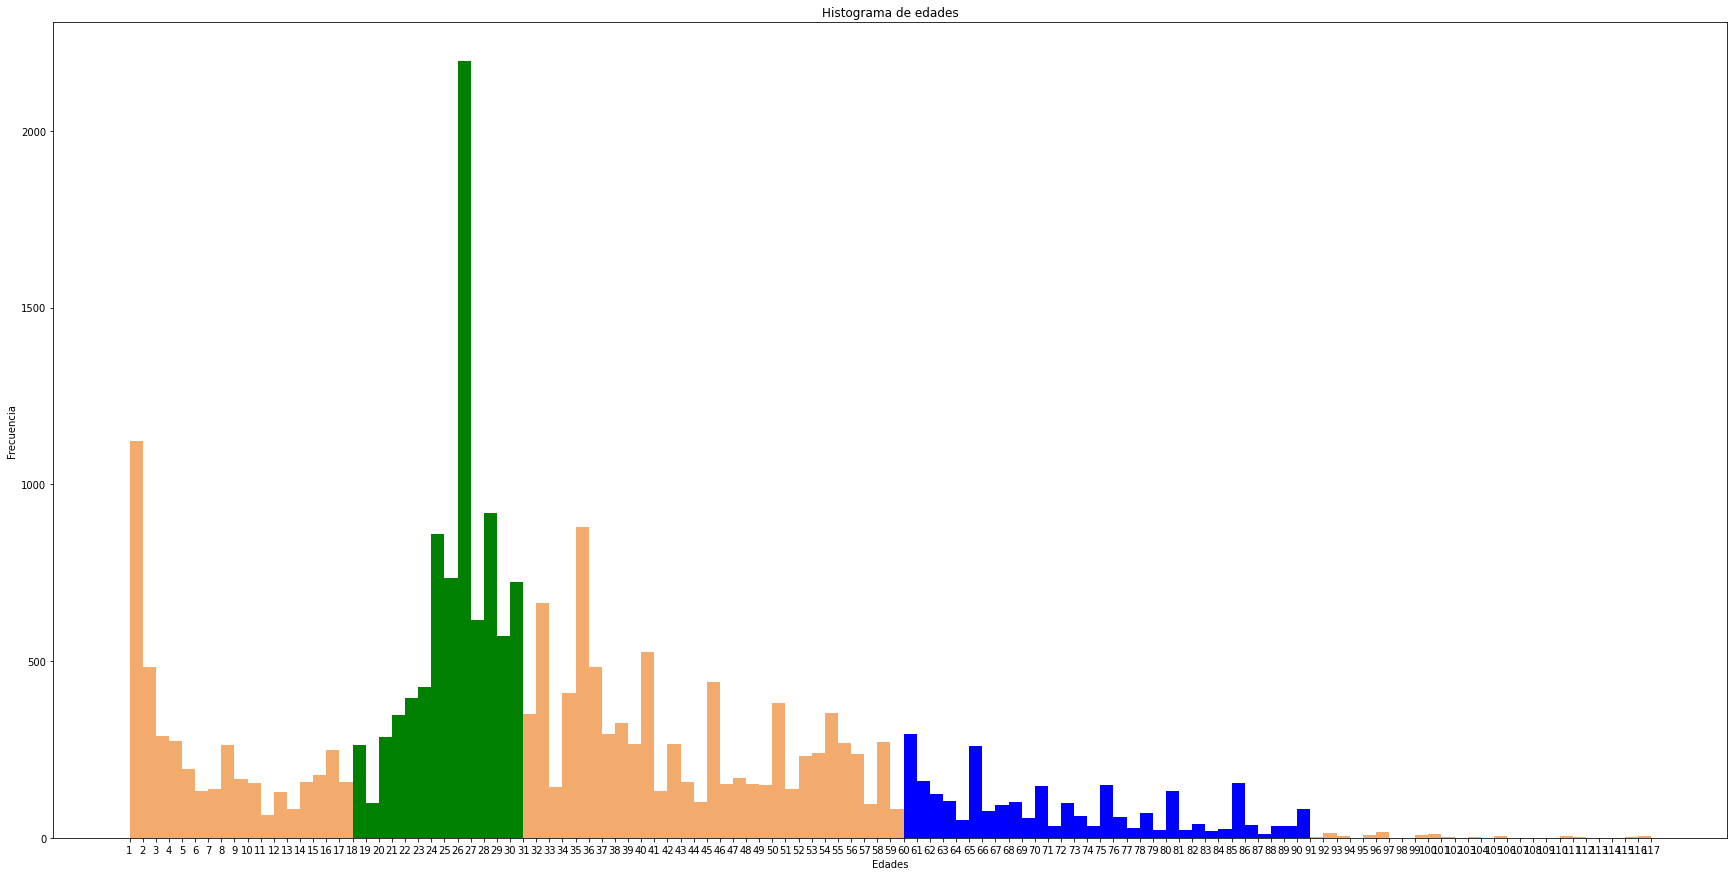

In [5]:
intervalos = range(min(labels), max(labels) + 2) #calculamos los extremos de los intervalos


plt.figure(figsize=(30,15))
plt.hist(x=labels, bins=intervalos, color='#F2AB6D')
plt.hist(x=labels_young, bins=intervalos, color='green')
plt.hist(x=labels_elderly, bins=intervalos, color='blue')
plt.title('Histograma de edades')
plt.xlabel('Edades')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)

plt.show() #dibujamos el histograma

In [8]:
# divide the young data into train and test

images_young_train = images_young[:-256]
images_young_test = images_young[-256:]
labels_young_train = labels_young[:-256]
labels_young_test = labels_young[-256:]

print("Total Train Labels:", len(labels_young_train))
print("Total Test Labels:", len(labels_young_test))

Total Train Labels: 8172
Total Test Labels: 256


In [9]:
sio.savemat(data_path+'/Data_Young.mat', {'X': images_young_train, 'L': labels_young_train})
sio.savemat(data_path+'/Data_Elderly.mat', {'X': images_elderly, 'L': labels_elderly})
sio.savemat(data_path+'/Data_Young_test.mat', {'X': images_young_test, 'L': labels_young_test})

print("Data_Young.mat:")
print(sio.whosmat(data_path+'/Data_Young.mat'))
mat_loaded = sio.loadmat(data_path+'/Data_Young.mat')
print(len(mat_loaded['X']))

print("Data_Elderly.mat")
print(sio.whosmat(data_path+'/Data_Elderly.mat'))
mat_loaded = sio.loadmat(data_path+'/Data_Elderly.mat')
print(len(mat_loaded['X']))

print("Data_Young_test.mat")
print(sio.whosmat(data_path+'/Data_Young_test.mat'))
mat_loaded = sio.loadmat(data_path+'/Data_Young_test.mat')
print(len(mat_loaded['X']))

Data_Young.mat:
[('X', (8172, 200, 200, 3), 'uint8'), ('L', (1, 8172), 'int64')]
8172
Data_Elderly.mat
[('X', (2603, 200, 200, 3), 'uint8'), ('L', (1, 2603), 'int64')]
2603
Data_Young_test.mat
[('X', (256, 200, 200, 3), 'uint8'), ('L', (1, 256), 'int64')]
256


In [ ]:
#Making native class loader
class FacesDB(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/example.mat', transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.label = mat_loaded['L'][0]
        self.transform = transform

    # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[index]  
        lbl = self.label[index]  
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl

    # Return the number of images
    def __len__(self):
        return self.data.shape[0]

/content/drive/Shared drives/DeepLearning_2022/Project/Data//Data_Young.mat
Images: torch.Size([100, 3, 200, 200])
Labels: torch.Size([100])


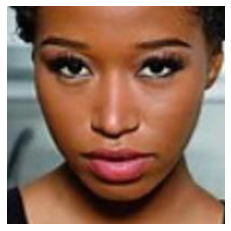

Ages: tensor(26)

/content/drive/Shared drives/DeepLearning_2022/Project/Data//Data_Elderly.mat
Images: torch.Size([100, 3, 200, 200])
Labels: torch.Size([100])


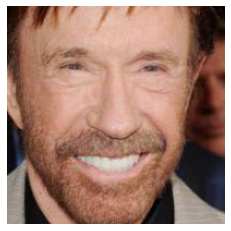

Ages: tensor(76)


In [ ]:
def prueva(path):
  print(path)

  ## obtain data
  tr = tf.Compose([
          tf.ToTensor(), 
          ])
  faces_db = FacesDB(path,tr)
  loader = torch.utils.data.DataLoader(dataset=faces_db,
                                            batch_size=100, 
                                            shuffle=True)

  # Mini-batch images
  images, labels = next(iter(loader))
  print("Images:",images.shape)
  print("Labels:",labels.shape)
  image = images[0,:,:,:]
  plt.imshow(image.permute(1,2,0).squeeze().numpy())
  plt.axis('off')
  plt.show()
  print("Ages:",labels[0])

  
prueva(data_path+'/Data_Young.mat')
print()
prueva(data_path+'/Data_Elderly.mat')